# Red wine quality

Practice ML model to determine red wine quality based on Kaggle dataset.

## 1. Imports

Import dependencies required by the app.

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import time
np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

## 2. Load dataset

Loads the dataset. Prints the first 5 rows to ensure everything is correct.

In [221]:
df = pd.read_csv('./data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Check if there is any null data that needs to be filled in:

In [222]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## 3. Prepare data

There's no null data, so we can continue with processing the dataset. Here, we analyze the features to see what we're working with.

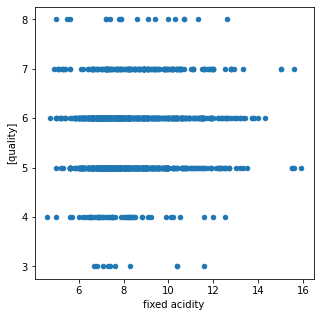

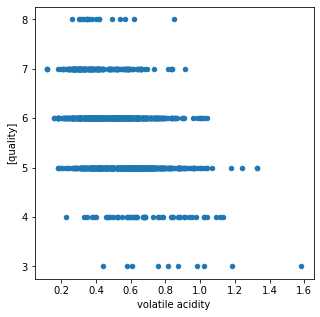

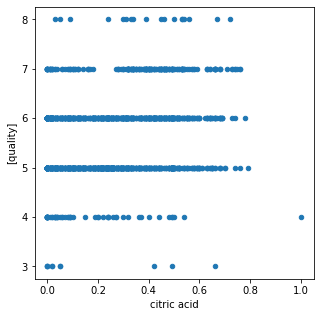

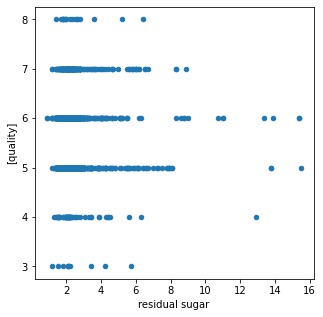

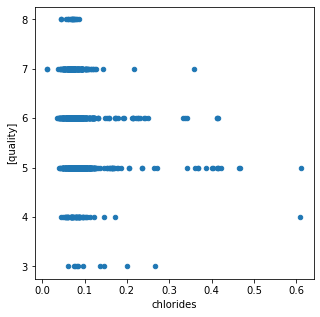

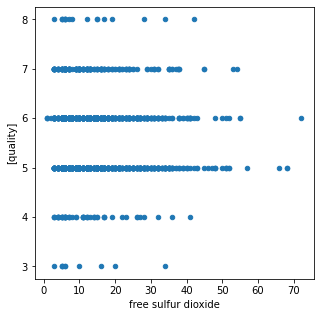

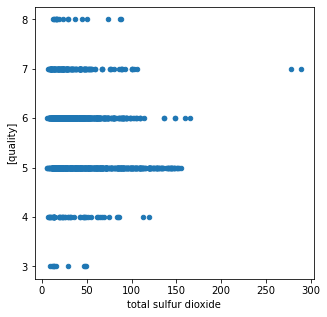

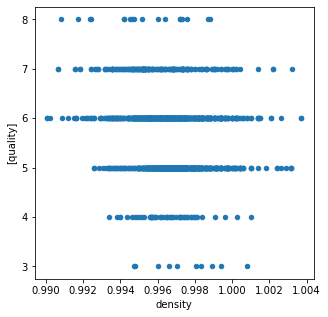

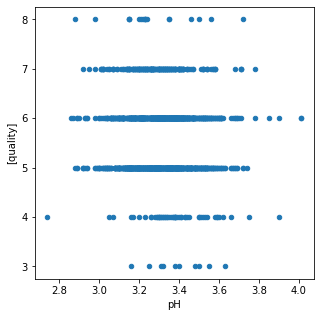

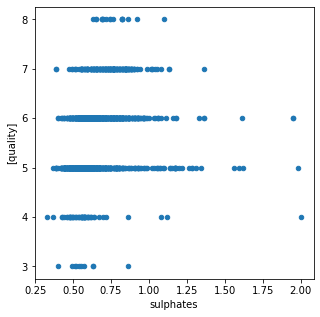

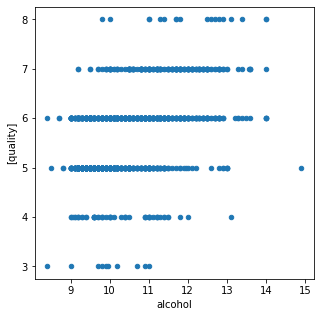

In [223]:
for i in df.columns:
    if i == 'quality':
        continue
    df.plot(x=i, y=["quality"],
                 kind="scatter", figsize=(5, 5))

    # display plot
    mp.show()

# TODO add plots to visualize linear dependency between data points. Then, in next step, extract one feature per set of linearily-dependent features (make sure data in selected feature doesn't converge to average)

Set up the x and y DataFrames. Extract NumPy ndarrays.

In [224]:
x_df = df.drop('quality', axis=1)
y_df = df[['quality']]

In [225]:
X = x_df.to_numpy()
# Scale all inputs from 0 to 1
print(X.max(axis=0))
X = X / X.max(axis=0)

[ 15.9       1.58      1.       15.5       0.611    72.      289.
   1.00369   4.01      2.       14.9    ]


Create a per-class y matrix.

In [226]:
nb_classes = 1  # All wine >= 6.5 is good quality.
y = (y_df.to_numpy() >= 6).astype(int)
pd.DataFrame(y).describe()

,0
count,1599.000000
mean,0.534709
std,0.498950
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Insert ones for w_0.

In [227]:
m = np.size(y.shape[0])
X = np.append(np.insert(X, 0, np.ones(m), axis=1), X * X, axis=1)

## 4. Create train/test/validate arrays

Create the train and test NumPy ndarrays with random data from dataset.

In [228]:
nb_samples = X.shape[0]
border1 = int(0.8*nb_samples)
border2 = int(0.9*nb_samples)

indices = np.random.permutation(nb_samples)
train_indices = indices[:border1]
validate_indices = indices[border1:border2]
test_indices = indices[border2:]

X_train = X[train_indices]
y_train = y[train_indices]

X_validate = X[validate_indices]
y_validate = y[validate_indices]

X_test = X[test_indices]
y_test = y[test_indices]

print(nb_samples, len(X_train), len(X_validate), len(X_test))

1599 1279 160 160


## 5. Training

The actual algorithm functions.

In [229]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))


def z(theta, x):
    theta = theta.reshape(len(X.T), 1)
    assert theta.shape[1] == 1
    # Theta should have as many rows as x has features.
    assert theta.shape[0] == x.shape[1]
    return np.dot(x, theta)


def hypothesis(theta, x):
    return sigmoid(z(theta, x))


def cost(theta, x, y):
    theta = theta.reshape(len(X.T), 1)
    y = y.reshape(len(y), 1)
    # x has a column for each feature, theta has a row for each feature.
    assert x.shape[1] == theta.shape[0]
    # One row per sample.
    assert x.shape[0] == y.shape[0]
    assert y.shape[1] == 1
    assert theta.shape[1] == 1
    h = hypothesis(theta, x)
    one_case = np.matmul(-y.T, np.log(h))
    zero_case = np.matmul(-(1 - y).T, np.log(1 - h))
    return (one_case + zero_case) / len(x)


def gradient_descent(theta, x, y, learning_rate, regularization=0):
    theta = theta.reshape(len(X.T), 1)
    y = y.reshape(len(y), 1)
    regularization = theta * regularization
    error = hypothesis(theta, x) - y
    n = (learning_rate / len(x)) * (np.matmul(x.T, error) + regularization)
    return theta - n


def minimize(theta, x, y, nb_classes, iterations, learning_rate, regularization=0):
    costs = []
    for iter in range(iterations):
        subcosts = []
        for i in range(nb_classes):
            theta[:, i] = gradient_descent(
                theta[:, i], x,
                y[:, i], learning_rate, regularization).flatten()
            subcosts.append(cost(theta[:, i],
                                 x, y[:, i])[0][0])
            costs.append(subcosts)
        print(
            f"Iteration {iter}: avg. cost = {np.average(np.asarray(costs[iter])): .2f}")
    return theta, costs


## 6. Run & evaluate

Run the data with a randomly-initialized Theta, and evaluate the results.

In [230]:
theta = np.random.rand(len(X.T), nb_classes)
theta, costs = minimize(theta, X_train, y_train, nb_classes, 50000, 0.01)


Iteration 0: avg. cost =  2.52
Iteration 1: avg. cost =  2.51
Iteration 2: avg. cost =  2.49
Iteration 3: avg. cost =  2.48
Iteration 4: avg. cost =  2.47
Iteration 5: avg. cost =  2.46
Iteration 6: avg. cost =  2.45
Iteration 7: avg. cost =  2.44
Iteration 8: avg. cost =  2.42
Iteration 9: avg. cost =  2.41
Iteration 10: avg. cost =  2.40
Iteration 11: avg. cost =  2.39
Iteration 12: avg. cost =  2.38
Iteration 13: avg. cost =  2.37
Iteration 14: avg. cost =  2.35
Iteration 15: avg. cost =  2.34
Iteration 16: avg. cost =  2.33
Iteration 17: avg. cost =  2.32
Iteration 18: avg. cost =  2.31
Iteration 19: avg. cost =  2.30
Iteration 20: avg. cost =  2.28
Iteration 21: avg. cost =  2.27
Iteration 22: avg. cost =  2.26
Iteration 23: avg. cost =  2.25
Iteration 24: avg. cost =  2.24
Iteration 25: avg. cost =  2.23
Iteration 26: avg. cost =  2.21
Iteration 27: avg. cost =  2.20
Iteration 28: avg. cost =  2.19
Iteration 29: avg. cost =  2.18
Iteration 30: avg. cost =  2.17
Iteration 31: avg.

In [231]:
y_pred = np.zeros((X_test.shape[0], nb_classes))
for i in range(nb_classes):
    y_pred[:, i] = (hypothesis(theta[:, i], X_test) > 0.5).astype(int).flatten()

for r in range(len(y_pred)):
    if y_pred[r, :].sum() > 1:
        print("Multiple qualities predicted:")
        print(y_pred[r, :])

pd.DataFrame(y_pred).describe()

,0
count,160.000000
mean,0.593750
std,0.492674
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [232]:
pd.DataFrame(y).sum()

0    855
dtype: int64

Check results in confusion matrix.

In [233]:
tp = (y_pred == 1) & (y_test == 1)
tpr = tp.sum() / (y_test == 1).sum()
print(tpr)

0.896551724137931


In [234]:
tn = (y_pred == 0) & (y_test == 0)
tnr = tn.sum() / (y_test == 0).sum()
print(tnr)

0.7671232876712328


In [235]:
fp = (y_pred == 1) & (y_test == 0)
fpr = fp.sum() / (y_test == 0).sum()
print(fpr)

0.2328767123287671


In [236]:
fn = (y_pred == 0) & (y_test == 1)
fnr = fn.sum() / (y_test == 1).sum()
print(fnr)

0.10344827586206896


Finally, we save the model for later use.

In [237]:
np.savetxt(f"models/theta-{int(time.time())}.csv", theta)